In [2]:
!git clone https://github.com/sevamoo/SOMPY.git

Cloning into 'SOMPY'...
remote: Enumerating objects: 947, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 947 (delta 20), reused 27 (delta 15), pack-reused 906 (from 1)
Receiving objects: 100% (947/947), 10.15 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (512/512), done.


In [3]:
!pip install ipdb
!pip install numexpr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [4]:
import sys
sys.path.append('/content/SOMPY')  # Add the SOMPY folder to the Python path

import sompy  # Now you can import sompy

NumExpr defaulting to 2 threads.


In [5]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from sompy.sompy import SOM
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.preprocessing import StandardScaler

In [6]:
df=pd.read_csv('df_PCA.csv',delimiter=',')

In [7]:
df.set_index('customer_id',inplace=True)

In [9]:
np.random.seed(42)

In [10]:
grid_sizes = [(10, 10), (15, 15), (20, 20), (25, 25), (30, 30),(35,35),(40,40),(45,45),(50,50)]
#

# Lists to store errors
topographic_errors = []
quantization_errors = []

# Train SOM for each grid size and record errors
for size in grid_sizes:
    sm = sompy.SOMFactory().build(
        df.values,
        mapsize=size,
        initialization='random',
        neighborhood='gaussian',
        training='batch',
        lattice='hexa'
    )
    sm.train(n_job=1, verbose='info', train_rough_len=100, train_finetune_len=200)

    # Collect errors
    topographic_errors.append(sm.calculate_topographic_error())
    quantization_errors.append(sm.calculate_quantization_error())

# Plotting
grid_sizes_flat = [s[0] * s[1] for s in grid_sizes]  # Flatten grid sizes into single values

plt.figure(figsize=(10, 6))

# Topographic error scatter plot
plt.scatter(grid_sizes_flat, topographic_errors, label="Topographic Error", color="blue")
plt.plot(grid_sizes_flat, topographic_errors, color="blue", linestyle="--", alpha=0.7)

# Quantization error scatter plot
plt.scatter(grid_sizes_flat, quantization_errors, label="Quantization Error", color="red")
plt.plot(grid_sizes_flat, quantization_errors, color="red", linestyle="--", alpha=0.7)

# Labels and Legend
plt.title("Topographic and Quantization Errors vs. Grid Size", fontsize=14)
plt.xlabel("Grid Size (Number of Nodes)", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.117000, quantization error: 11.894978

 epoch: 2 ---> elapsed time:  0.162000, quantization error: 3.959979

 epoch: 3 ---> elapsed time:  0.150000, quantization error: 3.935706

 epoch: 4 ---> elapsed time:  0.153000, quantization error: 3.913062

 epoch: 5 ---> elapsed time:  0.150000, quantization error: 3.896230

 epoch: 6 ---> elapsed time:  0.160000, quantization error: 3.883381

 epoch: 7 ---> elapsed time:  0.153000, quantization error: 3.875116

 epoch: 8 ---> elapsed time:  0.153000, quantization error: 3.870485

 epoch: 9 ---> elapsed time:  0.183000, quantization error: 3.866409

 epoch: 10 ---> elapsed time:  0.239000, quantization error: 3.863575

 epoch: 11 ---> elapsed time:  0.246000, quantization error: 3.861286

 epoch: 12 ---> elapsed time:  0.227000, quantization error: 3.859069

 epoch: 13 --->

KeyboardInterrupt: 

In [ ]:

sm = sompy.SOMFactory().build(
    df.values,
    mapsize=[30, 30],
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=df.columns
)
sm.train(n_job=1, verbose='info', train_rough_len=300, train_finetune_len=1000)

 Training...
 random_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 10.000000 , radius_final: 1.666667, trainlen: 300



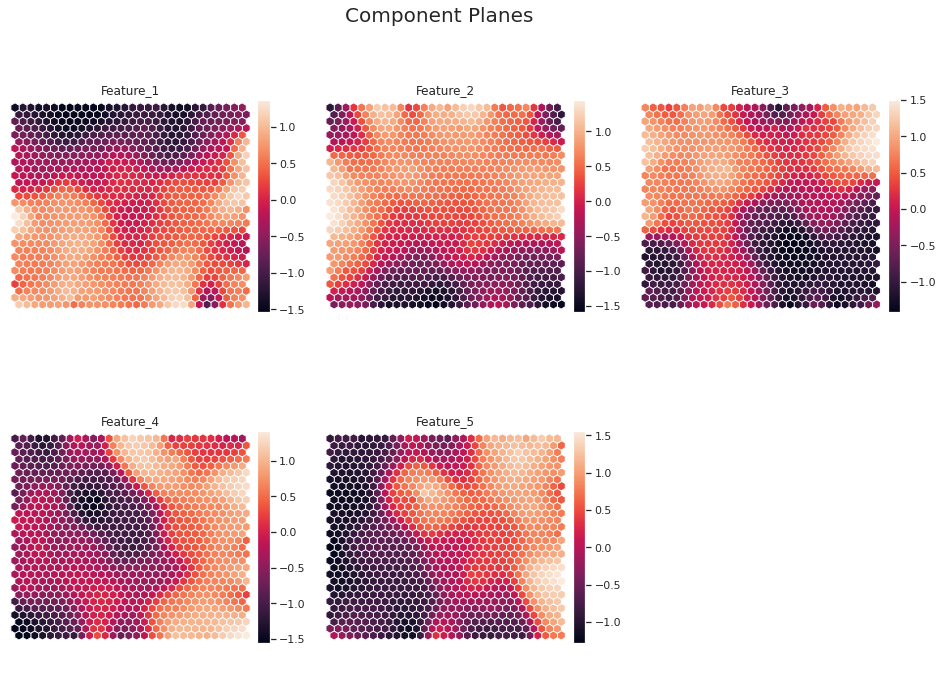

In [33]:
plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

In [ ]:
x=int(np.sqrt(5*np.sqrt(df.shape[0])))
y=x
input_len=df.shape[1]

In [ ]:
space={'sig':hp.uniform('sig',0.01,x/2.01),'learning_rate':hp.uniform('learning_rate',0.001,0.8)}
def son_fn(space):
  sig=space['sig']
  lr=space['learning_rate']
  val=MiniSom(x=x,y=y,input_len=input_len,sigma=sig,learning_rate=lr).quantization_error(df.values)
  return {'loss': val,'status':STATUS_OK}
trials = Trials()
best=fmin(fn=son_fn,space=space,algo=tpe.suggest,max_evals=200,trials=trials)
print('best:',format(best))

100%|██████████| 200/200 [01:49<00:00,  1.83trial/s, best loss: 1.218626099266434]
best: {'learning_rate': 0.48282222628042604, 'sig': 1.006560378937622}


In [ ]:
sigma=best['sig']
learning_rate=best['learning_rate']